# The prediction accuracy of subscribing to a game-related newsletter using gender, age, and played hours.

## Introduction

* This project will mainly focus on a dataset about how people play video games. It will use data from this dataset to calculate the prediction accuracy of different characteristics or behaviors. The goal is to identify which characteristics or behaviors are more predictive. In the future, these characteristics can be used to predict whether a player will subscribe to a game-related newsletter.

  
* According to the dataset provided by a research group in Computer Science at UBC, we will primarily analyze three characteristics and behaviors. The main research question of this project is: "Among gender, age, and hours played, which factor has the highest prediction accuracy for subscribing to a game-related newsletter?"

### Data information
  - The data is collected by a research group in Computer Science at UBC, led by Frank Wood, which is about how people played the game.
  - This dataset includes seven variables: experience, subscribe, hashed email, played hours, name, gender, and age. It has 196 observations.
  - Quantitative variable: played hours, age;  Qualitative variable: experience, subscribe, hashed email, name, gender.
  - The meaning of the variables:
    1. experience: The experience level of each player, is classified as "Pro", Veteran", "Amateur", "Beginner", and "Regular" five level.
    2. subscribe: Whether the player subscribes to the game-related newsletter or not. True means they subscribe, otherwise it gonna be false.
    3. hashed email: The email address of these players.
    4. played_hours: The time (in hours) that played totally played.
    5. name: The name of these players.
    6. gender: The gender of these players.
    7. Age: The age of these players.
  - There are some missing values in the age and gender variables, likely because these are private questions. When we perform our analysis, we will drop the missing values.
  - Since this project only analyzes how hours played, gender, and age predict subscription, we need to filter out the variables experience, hashedEmail, and name to tidy the data. At the same time, we also need to convert the data types of subscribe and name into factors. 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
player <- read_csv("data/players.csv")
player

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
player <- player |>
select(-hashedEmail, -name,-experience)|>
drop_na(subscribe, played_hours,Age)|>
mutate(subscribe = as_factor(subscribe), gender = as_factor(gender))|>
filter(gender != "Prefer not to say")
player

subscribe,played_hours,gender,Age
<fct>,<dbl>,<fct>,<dbl>
TRUE,30.3,Male,9
TRUE,3.8,Male,17
FALSE,0.0,Male,17
⋮,⋮,⋮,⋮
TRUE,0.0,Female,17
FALSE,0.3,Male,22
FALSE,2.3,Male,17


## Methods & Results

 First, I split the data into two parts with 75%-25%.
 ratio: 75% of the original data is used for training and the remaining 25% for testing. We will use the training data to build the model, and then apply the model to the testing data to calculate the prediction accuracy.

Since the subscribe variable is qualitative, we will use the K-Nearest Neighbors (KNN) classification model to make predictions. To evaluate how well each individual variable predicts subscription, I will use three different recipes, each including only one variable, and calculate their accuracy rates.

Additionally, I will use cross-validation to make the model more robust, since the dataset is relatively small. I will also use the tune function to find the best value of k for each variable.
 

In [4]:
player_split <- initial_split(player, prop = 0.75, strata = subscribe)
player_training <- training(player_split)
player_testing <- testing(player_split)
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("classification")
gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
player_vfold <- vfold_cv(data = player_training, v = 5, strata = subscribe)

### Part1: The relationship between the played hours and subscribe.

First, we will define a recipe that includes only the played hours variable, and then use it to tune and identify the best value of K for the K-Nearest Neighbors model.

In [5]:
player_recipe1 <- recipe( subscribe~ played_hours, data = player_training)|>
step_center(all_predictors())|>
step_scale(all_predictors())

player_workflow1 <- workflow()|>
add_recipe(player_recipe1)|>
add_model(player_spec)

player_results1 <- player_workflow1 |>
  tune_grid(resamples = player_vfold, grid = gridvals) |>
  collect_metrics()|>
  filter(.metric == "accuracy")

player_max1 <- player_results1 |>
   slice_max(mean)# No Answer - remove if you provide an answer
player_max1
player_results1

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.560989,5,0.04521214,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.3983516,5,0.02003800,Preprocessor1_Model01
2,accuracy,binary,0.4049451,5,0.01817345,Preprocessor1_Model02
3,accuracy,binary,0.4642857,5,0.03121488,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.5241758,5,0.05462406,Preprocessor1_Model08
9,accuracy,binary,0.5609890,5,0.04521214,Preprocessor1_Model09
10,accuracy,binary,0.5604396,5,0.04291346,Preprocessor1_Model10


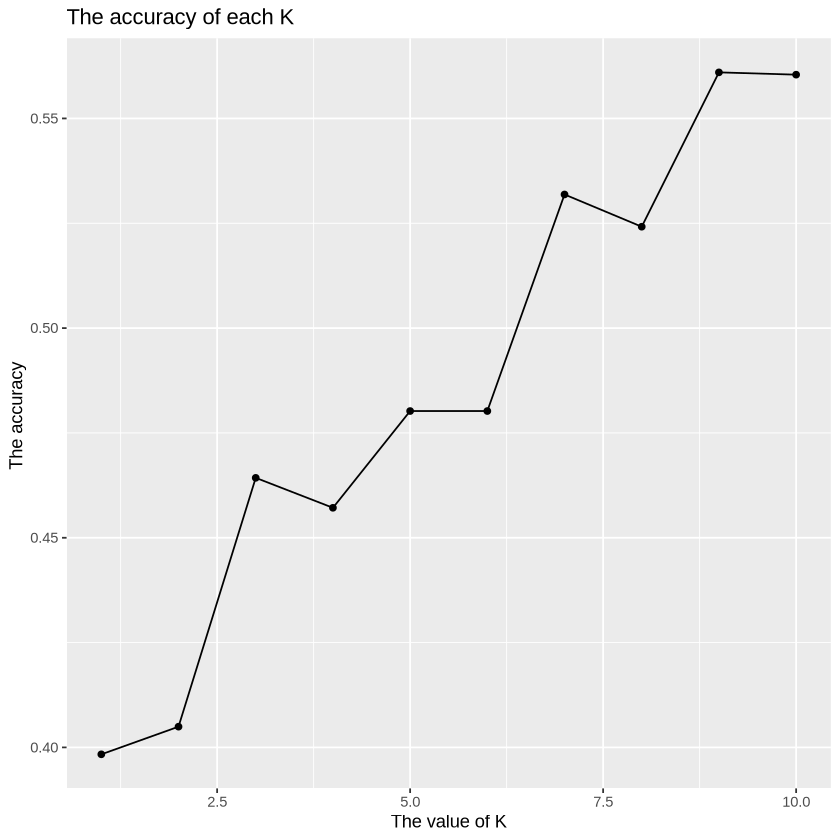

In [6]:
k_value_play_hour <- ggplot(player_results1, aes(x = neighbors, y= mean))+
geom_point()+
geom_line()+
labs(x = "The value of K", y = "The accuracy ")+
ggtitle("The accuracy of each K")

k_value_play_hour

According to the graph, we found that the best value of K is 8, as it gives the highest accuracy.

In [7]:
k_max <- player_max1 |>
         slice(1)|>
         pull(neighbors)

player_best_spec1 <- nearest_neighbor(weight_func = "rectangular", neighbors = k_max) |>
         set_engine("kknn") |>
         set_mode("classification")

player_best_fit1 <- workflow() |>
         add_recipe(player_recipe1) |>
         add_model(player_best_spec1) |>
         fit(data = player_training)

player_summary1 <- player_best_fit1 |>
          predict(player_testing)|>
          bind_cols(player_testing) |>
          metrics(truth = subscribe, estimate = .pred_class)
player_summary1

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.51063830
kap,binary,-0.03247373


*According to the summary table, we found that using players' played hours to predict whether they subscribe or not results in an accuracy rate of 51.1%.*

### Part2 :The relationship between the gender and subscribe.

In Part 2, our variable will be gender. Therefore, we will update the recipe to use gender instead. Besides that, since gender is qualitative data, we do not need to standardize it.

In [9]:
player_recipe2 <- recipe( subscribe~ gender, data = player_training)

player_workflow2 <- workflow()|>
add_recipe(player_recipe2)|>
add_model(player_spec)

player_results2 <- player_workflow2 |>
  tune_grid(resamples = player_vfold, grid = gridvals) |>
  collect_metrics()|>
  filter(.metric == "accuracy") 
player_max2 <- player_results2 |>
   slice_max(mean)# No Answer - remove if you provide an answer
player_max2
player_results2

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.2928571,5,0.02921145,Preprocessor1_Model07
8,accuracy,binary,0.2928571,5,0.02921145,Preprocessor1_Model08
9,accuracy,binary,0.2928571,5,0.02921145,Preprocessor1_Model09
10,accuracy,binary,0.2928571,5,0.02921145,Preprocessor1_Model10


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.2423077,5,0.004710557,Preprocessor1_Model01
2,accuracy,binary,0.2423077,5,0.004710557,Preprocessor1_Model02
3,accuracy,binary,0.2780220,5,0.030411480,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.2928571,5,0.02921145,Preprocessor1_Model08
9,accuracy,binary,0.2928571,5,0.02921145,Preprocessor1_Model09
10,accuracy,binary,0.2928571,5,0.02921145,Preprocessor1_Model10


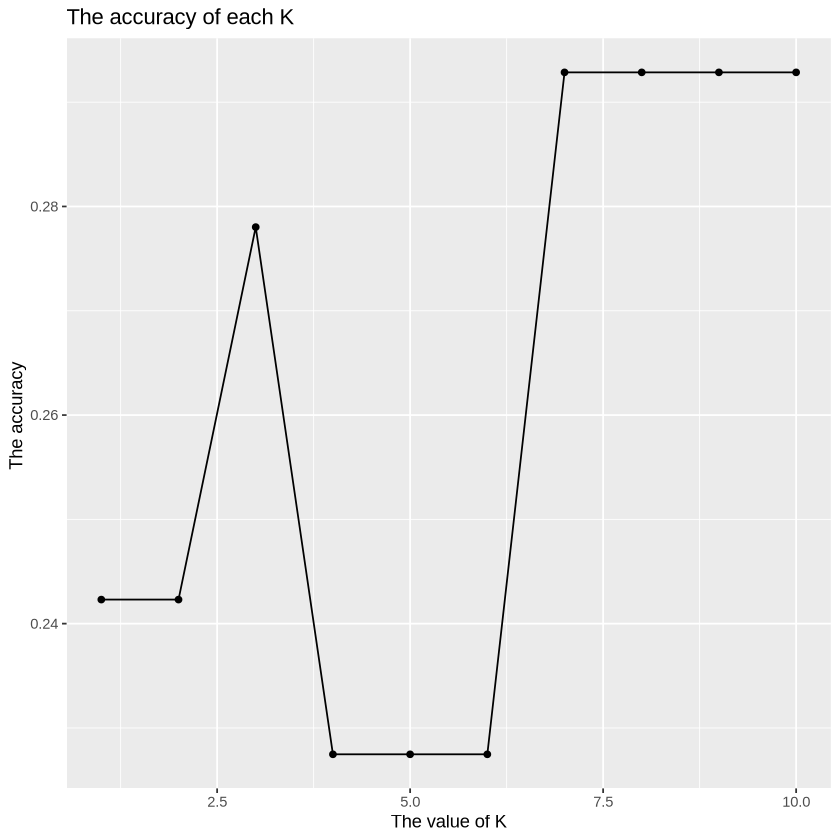

In [10]:
k_value_gender <- ggplot(player_results2, aes(x = neighbors, y= mean))+
geom_point()+
geom_line()+
labs(x = "The value of K", y = "The accuracy ")+
ggtitle("The accuracy of each K")

k_value_gender

In [11]:
k_max2 <- player_max2 |>
         slice(1)|>
         pull(neighbors)

player_best_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = k_max) |>
         set_engine("kknn") |>
         set_mode("classification")

player_best_fit2 <- workflow() |>
         add_recipe(player_recipe2) |>
         add_model(player_best_spec2) |>
         fit(data = player_training)

player_summary2 <- player_best_fit2 |>
          predict(player_testing)|>
          bind_cols(player_testing) |>
          metrics(truth = subscribe, estimate = .pred_class)
player_summary2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.25531915
kap,binary,-0.02876798


### Part3 :The relationship between the Age and subscribe.

In [13]:
player_recipe3 <- recipe( subscribe~ Age, data = player_training)

player_workflow3 <- workflow()|>
add_recipe(player_recipe3)|>
add_model(player_spec)

player_results3 <- player_workflow3 |>
  tune_grid(resamples = player_vfold, grid = gridvals) |>
  collect_metrics()|>
  filter(.metric == "accuracy") 
player_max3 <- player_results3 |>
   slice_max(mean)# No Answer - remove if you provide an answer
player_max3
player_results3

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.4824176,5,0.0451637,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.3879121,5,0.02800851,Preprocessor1_Model01
2,accuracy,binary,0.3879121,5,0.02800851,Preprocessor1_Model02
3,accuracy,binary,0.4538462,5,0.03437251,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.4164835,5,0.04670814,Preprocessor1_Model08
9,accuracy,binary,0.4824176,5,0.04516370,Preprocessor1_Model09
10,accuracy,binary,0.4747253,5,0.05121545,Preprocessor1_Model10


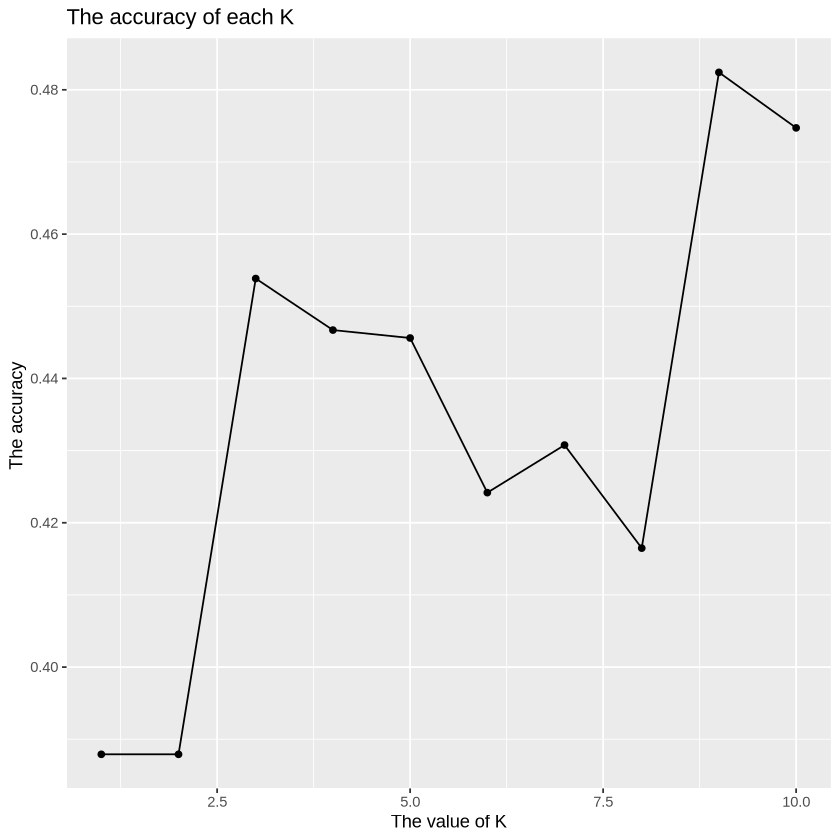

In [14]:
k_value_age <- ggplot(player_results3, aes(x = neighbors, y= mean))+
geom_point()+
geom_line()+
labs(x = "The value of K", y = "The accuracy ")+
ggtitle("The accuracy of each K")

k_value_age

In [15]:
k_max3 <- player_max3 |>
         slice(1)|>
         pull(neighbors)

player_best_spec3 <- nearest_neighbor(weight_func = "rectangular", neighbors = k_max) |>
         set_engine("kknn") |>
         set_mode("classification")

player_best_fit3 <- workflow() |>
         add_recipe(player_recipe3) |>
         add_model(player_best_spec3) |>
         fit(data = player_training)

player_summary3 <- player_best_fit3 |>
          predict(player_testing)|>
          bind_cols(player_testing) |>
          metrics(truth = subscribe, estimate = .pred_class)
player_summary3

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5744681
kap,binary,0.1910499


In [56]:
played_hour <- player_summary1 |>
filter(.metric == "accuracy")|>
pull(.estimate)
gender <- player_summary2 |>
filter(.metric == "accuracy")|>
pull(.estimate)
Age <- player_summary1 |>
filter(.metric == "accuracy")|>
pull(.estimate)

accuracy_bar <- tibble(characteristics = c("played_hour", "gender", "Age"),accuracy = c(played_hour, gender, Age))|>
ggplot(aes(x = characteristics, y = accuracy))+
geom_bar(stat = "identity")+
labs(x = "The characteristics of player", y = "The accuracy of each variable", title = "Prediction Accuracy by Variable")

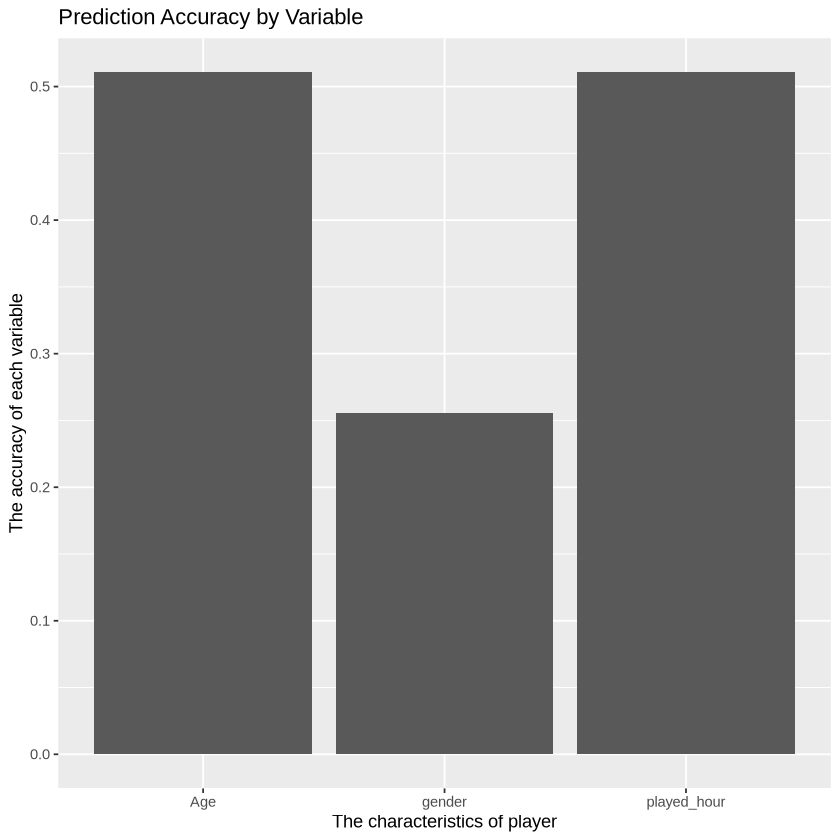

In [57]:
accuracy_bar